### Part 2: Residual VAE, we add another conditional VAE to model the reconstruction error
- X -> z0 -> X’
- D -> z1, (z1, X’) -> D’, where D = (X - X’)
- Randomly sample 10 X from test set, draw their (X, D, D’, X’ + D’) on the same plot
- MNIST: first stage BCE, second stage gaussian
- freyface: both stages are gaussian

#### 环境与参数设置

In [22]:
# 导入库
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.io import loadmat
import matplotlib.pyplot as plt

# --- 1. 环境与参数设置 ---
CONFIG = {
    "batch_size": 128,
    "epochs_stage1_mnist": 5,
    "epochs_stage2_mnist": 20,
    "epochs_stage1_frey": 50,
    "epochs_stage2_frey": 200,
    "lr": 1e-3,
    "seed": 1,
    "z_dim_stage1": 4,
    "z_dim_stage2": 4
}

torch.manual_seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('results_mnist', exist_ok=True)
os.makedirs('results_freyface', exist_ok=True)
os.makedirs('models', exist_ok=True)
print(f"Using device: {device}")

Using device: cuda


#### 模型与损失函数定义

In [23]:
# --- 2. 模型与损失函数定义 ---

# --- 第一阶段模型 ---
class VAE_Stage1_Binary(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(400, z_dim), nn.Linear(400, z_dim)
        self.decoder = nn.Sequential(nn.Linear(z_dim, 400), nn.ReLU(), nn.Linear(400, 784), nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

class VAE_Stage1_Gaussian(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(560, 200), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(200, z_dim), nn.Linear(200, z_dim)
        self.decoder_shared = nn.Sequential(nn.Linear(z_dim, 200), nn.ReLU())
        self.decoder_mean = nn.Sequential(nn.Linear(200, 560), nn.Sigmoid())
        self.decoder_logvar = nn.Linear(200, 560)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_shared(z)
        return self.decoder_mean(h), self.decoder_logvar(h)

    def forward(self, x):
        h = self.encoder(x.view(-1, 560))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        recon_mean, recon_logvar = self.decode(z)
        return recon_mean, recon_logvar, mu, logvar

# --- 第二阶段模型 (条件VAE) ---
class VAE_Stage2_Conditional(nn.Module):
    def __init__(self, input_dim, condition_dim, h_dim, z_dim):
        super().__init__()
        # 编码器输入是残差 D
        self.encoder = nn.Sequential(nn.Linear(input_dim, h_dim), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(h_dim, z_dim), nn.Linear(h_dim, z_dim)
        # 解码器输入是 z1 和条件 X' 的拼接
        self.decoder_shared = nn.Sequential(nn.Linear(z_dim + condition_dim, h_dim), nn.ReLU())
        self.decoder_mean = nn.Linear(h_dim, input_dim)
        self.decoder_logvar = nn.Linear(h_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, D, condition_X_prime):
        h = self.encoder(D)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z1 = self.reparameterize(mu, logvar)
        z1_and_condition = torch.cat([z1, condition_X_prime], dim=1)
        
        h_decoded = self.decoder_shared(z1_and_condition)
        recon_D_mean = self.decoder_mean(h_decoded)
        recon_D_logvar = self.decoder_logvar(h_decoded)
        
        return recon_D_mean, recon_D_logvar, mu, logvar

# --- 损失函数 ---
def loss_function_bce(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def loss_function_gaussian(recon_mean, recon_logvar, x, mu, logvar):
    x_flat = x.view(-1, recon_mean.shape[1])
    recon_err = (x_flat - recon_mean).pow(2)
    recon_loss = 0.5 * torch.sum(torch.exp(-recon_logvar) * recon_err + recon_logvar)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

#### 数据加载与准备

In [24]:
# --- 数据准备函数 ---
def prepare_residual_dataset(model, loader, device, is_frey=False):
    model.eval()
    all_residuals, all_recons = [], []
    print(f"Preparing residual dataset...")
    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            if is_frey:
                recon, _, _, _ = model(data)
                residual = data - recon
            else:
                recon, _, _ = model(data)
                residual = data.view(-1, 784) - recon
            all_residuals.append(residual.cpu())
            all_recons.append(recon.cpu())
            
    residual_dataset = TensorDataset(torch.cat(all_residuals), torch.cat(all_recons))
    return DataLoader(residual_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

#### MNIST Residual VAE 训练

In [25]:
print("--- Part 1: MNIST Residual VAE ---")
mnist_train_loader = DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()), batch_size=CONFIG['batch_size'], shuffle=True)
mnist_test_loader = DataLoader(datasets.MNIST('../data', train=False, transform=transforms.ToTensor()), batch_size=CONFIG['batch_size'], shuffle=False)

# 3.1 训练第一阶段
print("--- Training Stage 1 VAE on MNIST ---")
model_s1_mnist = VAE_Stage1_Binary(z_dim=CONFIG['z_dim_stage1']).to(device)
optimizer_s1_mnist = optim.Adam(model_s1_mnist.parameters(), lr=CONFIG['lr'])
for epoch in range(1, CONFIG['epochs_stage1_mnist'] + 1):
    model_s1_mnist.train()
    total_loss = 0
    for data, _ in mnist_train_loader:
        data = data.to(device)
        optimizer_s1_mnist.zero_grad()
        recon_batch, mu, logvar = model_s1_mnist(data)
        loss = loss_function_bce(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer_s1_mnist.step()
    print(f'====> Epoch: {epoch}, Average Loss: {total_loss / len(mnist_train_loader.dataset):.4f}')
torch.save(model_s1_mnist.state_dict(), 'models/vae_s1_mnist.pth')
print("Stage 1 MNIST model saved.")

# 3.2 训练第二阶段
mnist_residual_loader = prepare_residual_dataset(model_s1_mnist, mnist_train_loader, device)
model_s2_mnist = VAE_Stage2_Conditional(784, 784, 400, CONFIG['z_dim_stage2']).to(device)
optimizer_s2_mnist = optim.Adam(model_s2_mnist.parameters(), lr=CONFIG['lr'])
print("\n--- Training Stage 2 VAE on MNIST Residuals ---")
for epoch in range(1, CONFIG['epochs_stage2_mnist'] + 1):
    model_s2_mnist.train()
    total_loss = 0
    for D, X_prime in mnist_residual_loader:
        D, X_prime = D.to(device), X_prime.to(device)
        optimizer_s2_mnist.zero_grad()
        recon_D_mean, recon_D_logvar, mu, logvar = model_s2_mnist(D, X_prime)
        loss = loss_function_gaussian(recon_D_mean, recon_D_logvar, D, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer_s2_mnist.step()
    print(f'====> Epoch: {epoch}, Average Loss: {total_loss / len(mnist_residual_loader.dataset):.4f}')
torch.save(model_s2_mnist.state_dict(), 'models/vae_s2_mnist.pth')
print("Stage 2 MNIST model saved.")

--- Part 1: MNIST Residual VAE ---
--- Training Stage 1 VAE on MNIST ---


====> Epoch: 1, Average Loss: 173.7071
====> Epoch: 2, Average Loss: 145.4174
====> Epoch: 3, Average Loss: 141.0954
====> Epoch: 4, Average Loss: 138.4257
====> Epoch: 5, Average Loss: 136.6539
Stage 1 MNIST model saved.
Preparing residual dataset...

--- Training Stage 2 VAE on MNIST Residuals ---
====> Epoch: 1, Average Loss: -1392.0061
====> Epoch: 2, Average Loss: -1578.4201
====> Epoch: 3, Average Loss: -1846.1595
====> Epoch: 4, Average Loss: -1899.2375
====> Epoch: 5, Average Loss: -2045.5616
====> Epoch: 6, Average Loss: -2139.9952
====> Epoch: 7, Average Loss: -2095.2315
====> Epoch: 8, Average Loss: -2215.0308
====> Epoch: 9, Average Loss: -2180.7516
====> Epoch: 10, Average Loss: -2210.3799
====> Epoch: 11, Average Loss: -2231.6742
====> Epoch: 12, Average Loss: -2356.6732
====> Epoch: 13, Average Loss: -2422.8138
====> Epoch: 14, Average Loss: -2414.7635
====> Epoch: 15, Average Loss: -2373.7246
====> Epoch: 16, Average Loss: -2429.2695
====> Epoch: 17, Average Loss: -2452

#### Frey Face Residual VAE 训练

In [26]:
# --- 4. Frey Face 残差 VAE 流程 ---
print("\n--- Part 2: Frey Face Residual VAE ---")
frey_faces = loadmat("frey_rawface.mat")["ff"].T.astype('float32') / 255.0
frey_dataset = TensorDataset(torch.from_numpy(frey_faces))
frey_loader = DataLoader(frey_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# 4.1 训练第一阶段
model_s1_frey = VAE_Stage1_Gaussian(z_dim=CONFIG['z_dim_stage1']).to(device)
optimizer_s1_frey = optim.Adam(model_s1_frey.parameters(), lr=CONFIG['lr'])
print("--- Training Stage 1 VAE on Frey Face ---")
for epoch in range(1, CONFIG['epochs_stage1_frey'] + 1):
    model_s1_frey.train()
    total_loss = 0
    for data, in frey_loader:
        data = data.to(device)
        optimizer_s1_frey.zero_grad()
        recon_mean, recon_logvar, mu, logvar = model_s1_frey(data)
        loss = loss_function_gaussian(recon_mean, recon_logvar, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer_s1_frey.step()
    if epoch % 10 == 0:
        print(f'====> Epoch: {epoch}, Average Loss: {total_loss / len(frey_loader.dataset):.4f}')
torch.save(model_s1_frey.state_dict(), 'models/vae_s1_frey.pth')
print("Stage 1 Frey Face model saved.")

# 4.2 训练第二阶段
frey_residual_loader = prepare_residual_dataset(model_s1_frey, frey_loader, device, is_frey=True)
model_s2_frey = VAE_Stage2_Conditional(560, 560, 200, CONFIG['z_dim_stage2']).to(device)
optimizer_s2_frey = optim.Adam(model_s2_frey.parameters(), lr=CONFIG['lr'])
print("\n--- Training Stage 2 VAE on Frey Face Residuals ---")
for epoch in range(1, CONFIG['epochs_stage2_frey'] + 1):
    model_s2_frey.train()
    total_loss = 0
    for D, X_prime in frey_residual_loader:
        D, X_prime = D.to(device), X_prime.to(device)
        optimizer_s2_frey.zero_grad()
        recon_D_mean, recon_D_logvar, mu, logvar = model_s2_frey(D, X_prime)
        loss = loss_function_gaussian(recon_D_mean, recon_D_logvar, D, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer_s2_frey.step()
    if epoch % 10 == 0:
        print(f'====> Epoch: {epoch}, Average Loss: {total_loss / len(frey_residual_loader.dataset):.4f}')
torch.save(model_s2_frey.state_dict(), 'models/vae_s2_frey.pth')
print("Stage 2 Frey Face model saved.")


--- Part 2: Frey Face Residual VAE ---
--- Training Stage 1 VAE on Frey Face ---


====> Epoch: 10, Average Loss: -1183.2770
====> Epoch: 20, Average Loss: -1348.6369
====> Epoch: 30, Average Loss: -1409.2578
====> Epoch: 40, Average Loss: -1441.5851
====> Epoch: 50, Average Loss: -1463.4963
Stage 1 Frey Face model saved.
Preparing residual dataset...

--- Training Stage 2 VAE on Frey Face Residuals ---
====> Epoch: 10, Average Loss: -1283.6698
====> Epoch: 20, Average Loss: -1313.3679
====> Epoch: 30, Average Loss: -1370.0379
====> Epoch: 40, Average Loss: -1404.5408
====> Epoch: 50, Average Loss: -1404.0666
====> Epoch: 60, Average Loss: -1439.0401
====> Epoch: 70, Average Loss: -1434.3377
====> Epoch: 80, Average Loss: -1401.6781
====> Epoch: 90, Average Loss: -1448.1831
====> Epoch: 100, Average Loss: -1440.8522
====> Epoch: 110, Average Loss: -1426.5421
====> Epoch: 120, Average Loss: -1453.7073
====> Epoch: 130, Average Loss: -1467.0827
====> Epoch: 140, Average Loss: -1472.9306
====> Epoch: 150, Average Loss: -1479.7770
====> Epoch: 160, Average Loss: -1490.12

#### 可视化

Saved visualization to results_mnist/residual_comparison.png


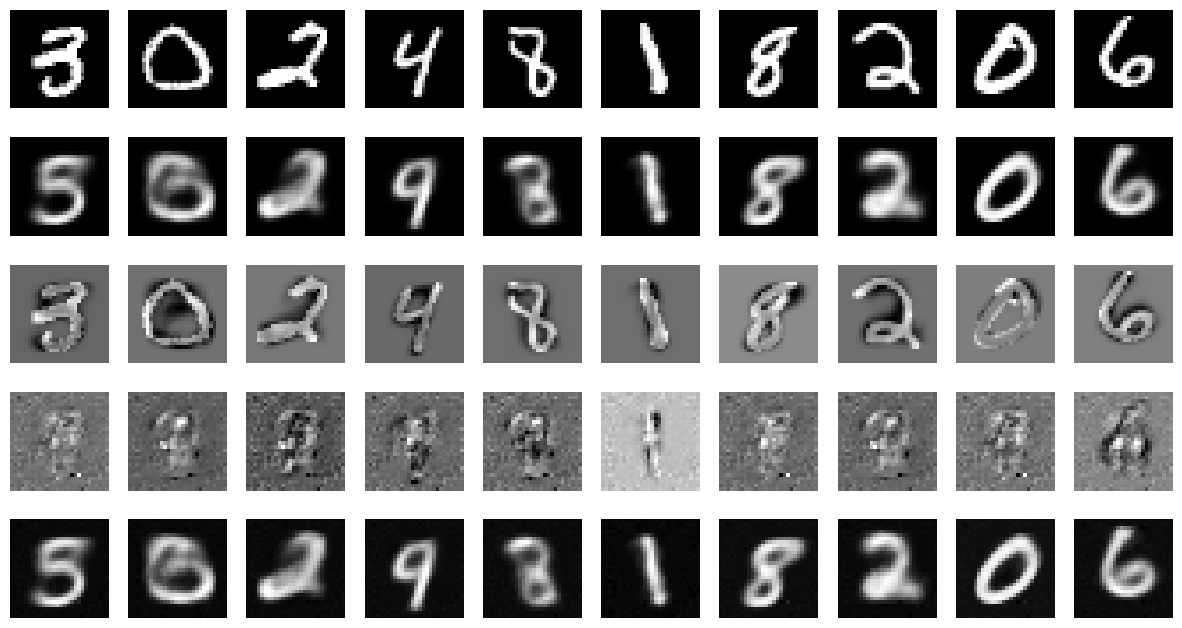

Saved visualization to results_freyface/residual_comparison.png


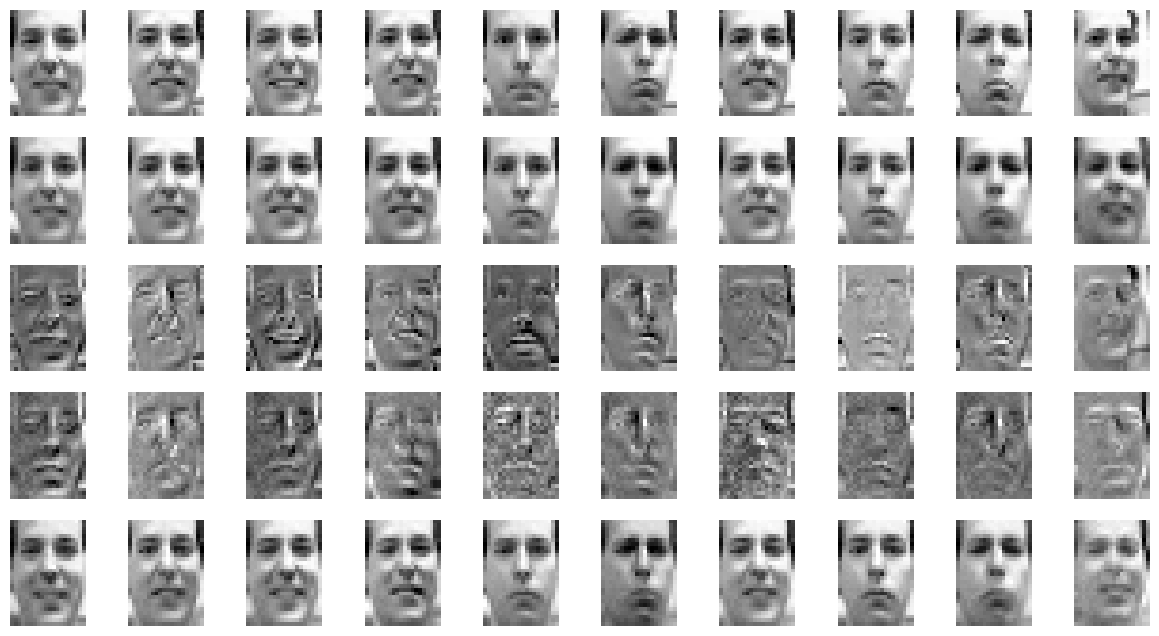

In [27]:
# --- 5. 可视化 ---
def visualize_residual_results(model_s1, model_s2, loader, num_samples, img_shape, result_path, is_frey=False):
    model_s1.eval(); model_s2.eval()
    
    if not getattr(loader.sampler, 'shuffle', False):
        temp_loader = DataLoader(loader.dataset, batch_size=loader.batch_size, shuffle=True)
        data_batch = next(iter(temp_loader))[0]
    else:
        data_batch = next(iter(loader))[0]
        
    X_sample = data_batch[:num_samples].to(device)

    with torch.no_grad():
        # --- Stage 1 ---
        if is_frey:
            X_prime_flat, _, _, _ = model_s1(X_sample)
        else:
            X_prime_flat, _, _ = model_s1(X_sample)
        
        # --- Stage 2 ---
        D_flat = X_sample.view(num_samples, -1) - X_prime_flat
        D_prime_flat, _, _, _ = model_s2(D_flat, X_prime_flat)
        
        # --- Final reconstruction ---
        X_final_flat = X_prime_flat + D_prime_flat

    # Reshape all tensors to 4D for visualization
    X = X_sample.view(num_samples, 1, *img_shape)
    X_prime = X_prime_flat.view(num_samples, 1, *img_shape)
    D = D_flat.view(num_samples, 1, *img_shape)
    D_prime = D_prime_flat.view(num_samples, 1, *img_shape)
    X_final = X_final_flat.view(num_samples, 1, *img_shape)

    comparison = torch.cat([X, X_prime, D, D_prime, X_final])
    save_image(comparison.cpu(), result_path, nrow=num_samples, normalize=True, value_range=(-1, 1))
    print(f"Saved visualization to {result_path}")
    
    # Plot in notebook
    fig, axes = plt.subplots(5, num_samples, figsize=(15, 8))
    
    titles = ["Original (X)", "Stage 1 Recon (X')", "Residual (D)", "Recon Residual (D')", "Final Recon (X'+D')"]
    images_to_plot = [X, X_prime, D, D_prime, X_final]
    
    for row_idx, row_images in enumerate(images_to_plot):
        axes[row_idx, 0].set_ylabel(titles[row_idx], rotation=0, size='large', labelpad=60)
        for col_idx in range(num_samples):
            ax = axes[row_idx, col_idx]
            img = row_images[col_idx].cpu().numpy().squeeze()
            ax.imshow(img, cmap='gray')
            ax.set_axis_off()
    plt.show()

# Visualize MNIST
visualize_residual_results(model_s1_mnist, model_s2_mnist, mnist_test_loader, 10, (28, 28), 'results_mnist/residual_comparison.png')

# Visualize Frey Face
frey_test_loader = DataLoader(frey_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
visualize_residual_results(model_s1_frey, model_s2_frey, frey_test_loader, 10, (28, 20), 'results_freyface/residual_comparison.png', is_frey=True)